# Deploy Model - By Member - Target 3HiGrp1 Chronic - (test RandomForest)

Prepared by Tan Bee Hoon  
Modified by Lien Wee Liang

16 Aug 2022  
21 Aug 2022 v1: Modified from Target All  
22 Aug 2022 v2: Modified target and scorelist

## Import Library

In [1]:
import random 
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import numpy as np 
from numpy import unique
from numpy import where

import pickle

from pandas import to_pickle
from pandas import read_pickle

import io

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance

# Libraries for Modelling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import NuSVC
from sklearn.svm import SVC
from sklearn import metrics 
from sklearn import tree
from sklearn.metrics import roc_auc_score

import scikitplot as skplt

import shap

from itertools import compress

import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

## Global Setting

###  Training Pickles Filename

In [2]:
PKL_ALL_FEATURE_FILENAME = "model_3HiGrp1_featurelist.pkl"

In [3]:
PKL_STANDARDSCALER_FILENAME = "model_3HiGrp1_standardard_scaler.pkl"

In [4]:
PKL_SELECT_MODEL_FILENAME = "model_3HiGrp1_selectfeature.pkl"

In [5]:
PKL_MODEL_FILENAME = "model_3HiGrp1_randomforest.pkl"

In [6]:
PKL_RESULT_FILENAME = "model_3HiGrp1_result_randomforest.pkl"

###  Testing Dataset

In [7]:
TEST_PREP_DATA = "member_test_data_final.pkl"

### Check is Target Label available

In [8]:
TARGET_AVAIL = 1

### Check Result

In [9]:
CHK_TRAIN_RESULT = 1

## Import Test Data

In [10]:
# Load Test Data
df = read_pickle(TEST_PREP_DATA)

In [11]:
df.shape

(6774, 427)

In [12]:
df.info("Deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6774 entries, 0 to 6773
Data columns (total 427 columns):
 #    Column                                                Dtype         
---   ------                                                -----         
 0    mem_id                                                object        
 1    gender                                                object        
 2    Mem_CountBooking                                      int64         
 3    AVE_mc_days                                           int64         
 4    AVE_count_diagnosis                                   int64         
 5    AVE_count_chronic                                     int64         
 6    AVE_count_medication                                  int64         
 7    AVE_count_repeatmed                                   int64         
 8    AVE_count_SymID                                       int64         
 9    age_yr                                                int64  

## Import Model Training Pickles

In [13]:
# Import training dataset feature list
with open(PKL_ALL_FEATURE_FILENAME, 'rb') as file:
    train_all_features = pickle.load(file)
print("Num of training features: ", len(train_all_features))

Num of training features:  143


In [14]:
# Import trained standard scaler model
with open(PKL_STANDARDSCALER_FILENAME, 'rb') as file:
    train_standardscaler = pickle.load(file)
train_standardscaler

StandardScaler()

In [15]:
# Import trained feature selection model
with open(PKL_SELECT_MODEL_FILENAME, 'rb') as file:
    train_selectfeature = pickle.load(file)
train_selectfeature

SelectFromModel(estimator=LogisticRegression(random_state=42), max_features=25)

In [16]:
# Import trained classification model 
with open(PKL_MODEL_FILENAME, 'rb') as file:
    train_model = pickle.load(file)
train_model

RandomForestClassifier(max_depth=10, max_features=25, min_samples_leaf=5,
                       min_samples_split=20, n_estimators=300, random_state=42)

In [17]:
if CHK_TRAIN_RESULT == 1:
    with open(PKL_RESULT_FILENAME, 'rb') as file:
        train_result = pickle.load(file)
train_result

,Train,Test
precision,0.931034,0.875000
recall,0.247706,0.152174
f1-score,0.391304,0.259259
support,109.000000,46.000000


## Prepare Scoring Data 

### Drop Redundant Data

In [18]:
drop_max = [col for col in df if col.startswith('MAX_')]

In [19]:
drop_min = [col for col in df if col.startswith('MIN_')]

In [20]:
# drop redundant variables
drop_list = ['FirstBookDate','LastBookDate', "WaviedCount_NA", 
             'Mode_consult_waived_reason', "Mode_consult_hr", 
                "ConsultHr_0",
                "ConsultHr_8", 
                "ConsultHr_9",
                "ConsultHr_10",                 
                "ConsultHr_11",
                "ConsultHr_12",
                "ConsultHr_13",
                "ConsultHr_14",
                "ConsultHr_15",
                "ConsultHr_16",
                "ConsultHr_17",
                "ConsultHr_18",
                "ConsultHr_19",
                "ConsultHr_20",
                "ConsultHr_21",
                "ConsultHr_22",
                "ConsultHr_23"]

In [21]:
final_drop = drop_max + drop_min + drop_list

In [22]:
df.drop(final_drop, inplace = True, axis = 1)

### Check Selected Input

In [23]:
all_list = df.columns.tolist()

In [24]:
#[TODO] TO INCLUDE CATEGORICAL INPUT TO CONSIDER
cat_list = ["gender"]  
df[cat_list] = df[cat_list].astype("category")

In [25]:
#[TODO] EDIT WHERE NEC
exc_list = ['mem_id', 
            'Target_Chronic',
            #'Target_Dermatitis',
            #'Target_Migraine',
            #'Target_Allergic',
            #'Target_Gastro',
            'Target_Hypertension',
            #'Target_Asthma',
            'Target_Hyperlipidaemia',
            #'Target_Thyroid',
            'Target_Diabetes',
            #'Target_Gout', 
            "CountVisit_Target_chronic",
            "AVE_count_chronic", 
            'CountVisit_symp_chronic_medicine_top-up',
            'CountVisit_symp_chronic_illness_management',
            # Added by LWL (seems all 0): CountVisit_chronic_list
            "CountVisit_chronic_list",
            "CountVisit_chronic_NoneChronic", 
            #"CountVisit_chronic_Atopic_dermatitis",
            #"CountVisit_chronic_Migraine",
            #"CountVisit_chronic_Vasomotor_and_allergic_rhinitis",
            #"CountVisit_chronic_Gastro-oesophageal_reflux_disease",
            "CountVisit_chronic_Hypertension",
            #"CountVisit_chronic_Asthma",
            "CountVisit_chronic_Hyperlipidaemia",
            #"CountVisit_chronic_Thyroid",
            "CountVisit_chronic_Diabetes",
            #"CountVisit_chronic_Gout", 
            #"CountVisit_diag_J30",  #Vasomotor and allergic rhinitis
            #"CountVisit_diag_K21",  #Gastro-esophageal reflux disease
            #"CountVisit_diag_G43",  #Migraine
            #"CountVisit_diag_L20",  #Atopic dermatitis
            #"CountVisit_diag_M10",  #Gout
            "CountVisit_diag_I10",  #hypertension
            #"CountVisit_diag_J45",  #Asthma
            "CountVisit_diag_E11",  #Diabetes
            "CountVisit_diag_E78",  #hypercholesterolemia, hyperglyceridemia, Hyperlipidemia (high cholesterol), Hyperchylomicronemia 
            #"CountVisit_diag_E03",  #Other hypothyroidism, i.e. Thyroid 
            #"CountVisit_diag_E05",  #Thyrotoxicosis [hyperthyroidism], i.e. Thyroid
            "Target_3High",                                           
            "Target_Allergic_Dermatitis_Asthma",                                                   
            "Target_Migraine_Gastro_Thyroid_Gout",                     
            "CountVisit_symp_headache",           
            "CountVisit_symp_giddiness",             
            "CountVisit_symp_cold_sores", 
            "CountVisit_symp_rash",      
            "CountVisit_symp_sore_throat",  
            "CountVisit_symp_flu",          
            "CountVisit_symp_cough", 
            "CountVisit_symp_cold",    
            "CountVisit_symp_vomiting", 
            "CountVisit_symp_diarrhoea", 
           ] 

In [26]:
# select columns not in exclusion list above
select_col = [x for x in all_list if x not in exc_list] 

In [27]:
# numerical data in selected list above
num_list = [x for x in select_col if x not in cat_list] 

In [28]:
# Check that all columns used in training are in the holdout test set.  
# If not, create a new column with value 0
for i in train_all_features:
    if i not in select_col:
        if str(i).startswith('gender')==False:  #TODO need to include other categorical data if nec
            print("PLEASE CHECK, Selected field in training dataset not in this test dataset, : ", i)
            df[i] = 0
            num_list.append(i)

In [29]:
# Only include input variables available in training input list
num_list_final = [x for x in num_list if x in train_all_features] 

### One Hot Encoding 

In [30]:
# Get encoded df for categorical data
enc_df = pd.get_dummies(df[cat_list])

In [31]:
# Drop "gender_Unknown"
drop_oneHot = ["gender_Female", "gender_Male"]

In [32]:
#[TODO] TO EDIT AND DROP ONE CATEGORY LEVEL FOR ONE-HOT
enc_df = enc_df[drop_oneHot]

### Define input and output

In [33]:
# merge with numerical df for input
X = df[num_list_final].join(enc_df)   

In [34]:
X.shape

(6774, 143)

In [35]:
# Define the Target
if TARGET_AVAIL ==1:
    y = df["Target_3High"]  
else:
    print("no target label")

In [36]:
member_id = df["mem_id"]  

In [37]:
# Check input variable names
feature_names = X.columns.tolist()
feature_names

['Mem_CountBooking',
 'AVE_mc_days',
 'AVE_count_diagnosis',
 'AVE_count_medication',
 'AVE_count_repeatmed',
 'AVE_count_SymID',
 'age_yr',
 'WaviedCount_FOLLOW_UP',
 'WaviedCount_HEALTH_SCREENING_REVIEW',
 'WaviedCount_OTHERS',
 'WaviedCount_REFERRAL',
 'WaviedCount_UNSUITABLE_FOR_TELECONSULT',
 'WaviedCount_WHITECOAT_FAMILY',
 'CountVisit_is_mc_issued',
 'CountVisit_is_referral_letter_issued',
 'CountVisit_diag_U12',
 'CountVisit_diag_J30',
 'CountVisit_diag_T88',
 'CountVisit_diag_K12',
 'CountVisit_diag_R21',
 'CountVisit_diag_A09',
 'CountVisit_diag_H57',
 'CountVisit_diag_Z02',
 'CountVisit_diag_J06',
 'CountVisit_diag_Z76',
 'CountVisit_diag_M79',
 'CountVisit_diag_R51',
 'CountVisit_diag_M54',
 'CountVisit_diag_R22',
 'CountVisit_diag_L50',
 'CountVisit_diag_B35',
 'CountVisit_diag_K30',
 'CountVisit_diag_O91',
 'CountVisit_diag_R07',
 'CountVisit_diag_M10',
 'CountVisit_diag_Z71',
 'CountVisit_diag_N94',
 'CountVisit_diag_K29',
 'CountVisit_diag_B37',
 'CountVisit_diag_R50',


In [38]:
if len(feature_names) == len(train_all_features):
    print("ok, training input features and testing input features mapped")
else: 
    print('\n Dropping columns from original columns with ', len(X.columns) , ' columns')
    # Add code to keep only columns in training set 
    X = X[train_all_features]
    print('\n Modified dataset has ', len(X.columns), ' columns')
    # See features in test data but not in training data 
    excluded_test_feature_list=[]
    for f in feature_names:
      if f not in train_all_features:
        excluded_test_feature_list.append(f)
    print(excluded_test_feature_list)

ok, training input features and testing input features mapped


### Standardized Data

In [39]:
# Transform the testing dataset
print("Transform the testing dataset (no fitting)")
X = train_standardscaler.transform (X)

Transform the testing dataset (no fitting)


## Model Result

### Model Selected Features

In [40]:
X_selected = train_selectfeature.transform(X)

In [41]:
feature_idx= train_selectfeature.get_support()
final_selectList = list(compress(feature_names, feature_idx))

In [42]:
print("Number of BEST features from SELECTMODEL: ", len(final_selectList))
print("\n\nList of selected BEST features from SELECTMODEL: \n", final_selectList)

Number of BEST features from SELECTMODEL:  25


List of selected BEST features from SELECTMODEL: 
 ['Mem_CountBooking', 'AVE_mc_days', 'AVE_count_diagnosis', 'age_yr', 'CountVisit_diag_R21', 'CountVisit_diag_A09', 'CountVisit_diag_M54', 'CountVisit_diag_R22', 'CountVisit_diag_O91', 'CountVisit_diag_H00', 'CountVisit_diag_L02', 'CountVisit_diag_J45', 'CountVisit_diag_G44', 'CountVisit_diag_H93', 'CountVisit_diag_S93', 'CountVisit_symp_N', 'CountVisit_symp_discuss_lab_results', 'DiffDays_Vist', 'Target_Allergic', 'ConsultHr_8to10', 'ConsultHr_11to13', 'ConsultHr_14to17', 'ConsultHr_18to21', 'Prin1_sym_common', 'gender_Female']


### Model ROC & AUC

In [43]:
model_probs = train_model.predict_proba(X_selected)[:,1]
    
if TARGET_AVAIL == 1:
    model_auc = roc_auc_score(y, model_probs, average=None)
else:
    print("No Target label, thus, auc not computed")

Model:  RandomForestClassifier
Model AUC:  0.915


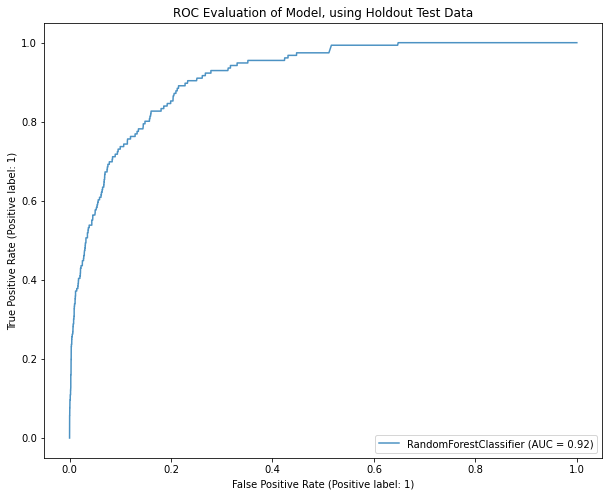

In [44]:
if TARGET_AVAIL == 1:
    print("Model: ", type(train_model).__name__)
    print("Model AUC: ", round(model_auc,3))
    %matplotlib inline
    plt.figure(figsize=(10,8))
    ax = plt.gca()
    model_disp = RocCurveDisplay.from_estimator(train_model, X_selected, y, ax=ax, alpha=0.8)
    plt.title("ROC Evaluation of Model, using Holdout Test Data")
    plt.show()
else:
    print("No Target label, thus, roc not plotted")

### Model Classification Report

In [45]:
#Define Target Names
target_names = ['Non-3High', '3High']

In [46]:
print("The model loaded: ", type(train_model).__name__)
param = train_model.get_params()
print("\nThe following are the trained model parameters: ", param)

The model loaded:  RandomForestClassifier

The following are the trained model parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 25, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [47]:
# get prediction
prediction = train_model.predict(X_selected)

In [48]:
# Generate Confusion Matrix
if TARGET_AVAIL == 1:
    conf_matrix = metrics.confusion_matrix(y, prediction)
else:
    print("Target not available, thus confucion matrix not generated.")

For Holdout Test Data:
Target:  ['Non-3High', '3High']
Model:  RandomForestClassifier

Confusion Matrix: 
 [[6615    3]
 [ 145   11]] 



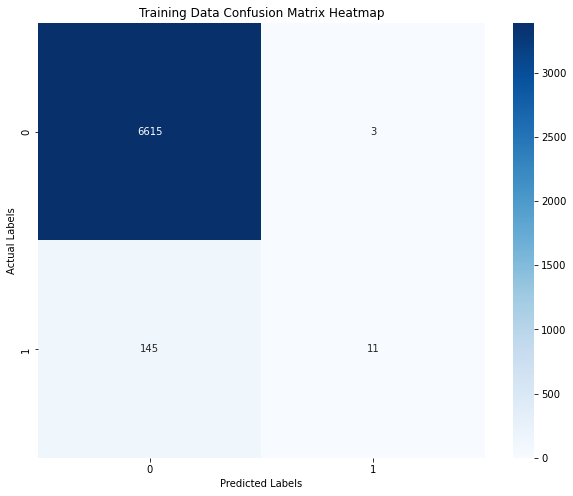

              precision    recall  f1-score   support

   Non-3High     0.9786    0.9995    0.9889      6618
       3High     0.7857    0.0705    0.1294       156

    accuracy                         0.9782      6774
   macro avg     0.8821    0.5350    0.5592      6774
weighted avg     0.9741    0.9782    0.9691      6774
 



In [49]:
# Generate Classification Report
if TARGET_AVAIL == 1:
    print("For Holdout Test Data:")
    print("Target: ", target_names)
    print("Model: ", type(train_model).__name__)
    print("\nConfusion Matrix: \n", conf_matrix, "\n")
    %matplotlib inline
    plt.figure(figsize=(10,8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', vmin=0, vmax=y.shape[0]/len(y.unique()), cmap="Blues")
    plt.title("Training Data Confusion Matrix Heatmap")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()
    print(metrics.classification_report(y, prediction,  digits=4, target_names=target_names), "\n" )
    report_dict_holdout = classification_report(y, prediction, output_dict=True)
    report_df_holdout = pd.DataFrame(report_dict_holdout)
    report_tgt_holdout = report_df_holdout["1"]
else:
    print("Target not available, thus classification report not generated.")

## Compare Result

In [50]:
# Check Training Result
if CHK_TRAIN_RESULT == 1:
    print("Model: ", type(train_model).__name__, "\n")
    
    compare = pd.concat([train_result, report_tgt_holdout], axis=1)
    col_name = ["Train", "Test", "Holdout"]
    compare.columns = col_name
    print(compare.transpose())
    
    if TARGET_AVAIL == 1:
        print("\nModel Holdout AUC: ", round(model_auc,3))

Model:  RandomForestClassifier 

         precision    recall  f1-score  support
Train     0.931034  0.247706  0.391304    109.0
Test      0.875000  0.152174  0.259259     46.0
Holdout   0.785714  0.070513  0.129412    156.0

Model Holdout AUC:  0.915


## Generate Score List

In [51]:
predict_series = pd.Series(prediction)

In [52]:
if TARGET_AVAIL == 1:
    df_scorelist = pd.DataFrame(columns = ["member_id", "true_target", "prediction"])
    df_scorelist["member_id"] = member_id
    df_scorelist["true_target"] = y
    df_scorelist["prediction"] = predict_series
else:
    df_scorelist = pd.DataFrame(columns = ["member_id", "prediction"])
    df_scorelist["member_id"] = member_id
    df_scorelist["prediction"] = predict_series


In [53]:
print(df_scorelist.head())

                              member_id  true_target  prediction
0  00059B0F-87F5-4D64-A5C8-441457913282            0           0
1  000789AE-E161-4FDE-B9B0-9377AB383A1B            1           0
2  0008AEAF-0767-46A2-830F-C98A9B88FF34            0           0
3  000C3E29-2C23-4EB0-A1FB-837EC7EA9E59            0           0
4  001C4B02-1827-4F58-85E8-AB985B27496A            0           0


In [54]:
df_scorelist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6774 entries, 0 to 6773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   member_id    6774 non-null   object
 1   true_target  6774 non-null   int64 
 2   prediction   6774 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 469.7+ KB


In [55]:
if type(train_model).__name__=="SVC":
    FILE_NAME = "scorelist_" + str(type(train_model).__name__) + str(param["kernel"]) + "_3HiGrp1.csv"
else:
    FILE_NAME = "scorelist_" + str(type(train_model).__name__) + "_3HiGrp1.csv"
print(FILE_NAME)
df_scorelist.to_csv(FILE_NAME, index=False)

scorelist_RandomForestClassifier_3HiGrp1.csv


@end